In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 11411 (delta 15), reused 19 (delta 0), pack-reused 11351
Receiving objects: 100% (11411/11411), 12.79 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (7930/7930), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [ ]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj): 
  if obj.find('name').text in ("with_mask",'mask'): 
    return 2 
  elif obj.find('name').text in ("mask_weared_incorrect",'poor'): 
    return 3 
  return 1


def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # Annotation is in dictionary format        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return target


In [ ]:
root = '/content/drive/MyDrive/Visión Computacional/Proyecto Final/'
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
class MaskDataset(object):
    def __init__(self, transforms,kind,root):
        #Kind : 'train' or 'test'
        #root : Should end in /
        self.transforms = transforms
        self.kind = kind
        #all_imgs = os.listdir(path+kind+'/images')
        self.total_imgs =list(sorted(os.listdir(root+kind + "/images")))
        self.total_annotations =list(sorted(os.listdir(root+kind + "/annotations")))
        self.root = root

    def __getitem__(self, idx):
        # load images ad masks
        file_image = self.total_imgs[idx]
        file_label = self.total_annotations[idx]
        img_path = os.path.join(self.root + self.kind + "/images", file_image)
        label_path = os.path.join(self.root + self.kind + "/annotations", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.total_imgs)

In [ ]:
data_transform = transforms.Compose([transforms.ToTensor(), ])
def collate_fn(batch):
  return tuple(zip(*batch))

# Definiendo las particiones de train y test

In [ ]:
dataset_train = MaskDataset(data_transform,'Train',root)
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=5 , num_workers=4, collate_fn=collate_fn)

In [ ]:
dataset_test = MaskDataset(data_transform,'Test',root)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=5,num_workers=4, collate_fn=collate_fn)

In [ ]:
len(dataset_train.total_imgs)

853

[{boxes , labels , ids}]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
torch.cuda.is_available()

True

# Model

In [ ]:
def get_model_instance_segmentation(num_classes):
  # load an instance segmentation model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

  return model

In [ ]:
model = get_model_instance_segmentation(3)

In [ ]:
10%5

0

# Train Model

In [ ]:
num_epochs = 15
model.to(device)
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    if (epoch+1)%5==0:
      torch.save(model.state_dict(),root+'Models/model_zombie_'+str(epoch+1)+'.pth')

Epoch: [0]  [  0/171]  eta: 0:13:46  lr: 0.000034  loss: 1.5602 (1.5602)  loss_classifier: 1.3046 (1.3046)  loss_box_reg: 0.1392 (0.1392)  loss_objectness: 0.0888 (0.0888)  loss_rpn_box_reg: 0.0276 (0.0276)  time: 4.8352  data: 2.7370  max mem: 8280
Epoch: [0]  [ 10/171]  eta: 0:06:12  lr: 0.000328  loss: 1.5602 (1.3777)  loss_classifier: 1.1298 (1.0349)  loss_box_reg: 0.1318 (0.1468)  loss_objectness: 0.1712 (0.1718)  loss_rpn_box_reg: 0.0238 (0.0241)  time: 2.3144  data: 0.2602  max mem: 9472
Epoch: [0]  [ 20/171]  eta: 0:05:52  lr: 0.000622  loss: 0.8533 (1.0298)  loss_classifier: 0.4476 (0.7004)  loss_box_reg: 0.1753 (0.1859)  loss_objectness: 0.1108 (0.1185)  loss_rpn_box_reg: 0.0167 (0.0251)  time: 2.2122  data: 0.0136  max mem: 10395
Epoch: [0]  [ 30/171]  eta: 0:05:24  lr: 0.000916  loss: 0.5815 (0.9506)  loss_classifier: 0.3130 (0.6005)  loss_box_reg: 0.2498 (0.2325)  loss_objectness: 0.0300 (0.0939)  loss_rpn_box_reg: 0.0141 (0.0237)  time: 2.2969  data: 0.0148  max mem: 1039

In [ ]:
for imgs, annotations in data_loader_test:
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  break


In [ ]:
model.eval()
preds = model(imgs)


# Function to plot image

In [ ]:
def plot_image(img_tensor, annotation,kind = 'orig', block=True):
  #Kind : Orig : to plot the original image
  #Kind : Pred : To plot the prediction
  fig,ax = plt.subplots(1)
  img = img_tensor.cpu().data
  # Display the image
  ax.imshow( np.array( img.permute(1, 2, 0) ) )
  if kind == 'orig':
    box_label_score = zip( annotation["boxes"], annotation["labels"])
    score = 1
  else:
    box_label_score = zip( annotation["boxes"], annotation["labels"] , annotation['scores'])

  for element in box_label_score:
    if kind == 'orig':
      box, label = element
    else:
      box,label,score = element
    xmin, ymin, xmax, ymax = box
    # Crear bounding box
    if score >0.8:
      if label ==2:
        color = 'g'
      elif label ==3:
        color = 'y'
      elif label ==1:
        color = 'r'
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.axis()
  plt.show(block=block)


Prediccion


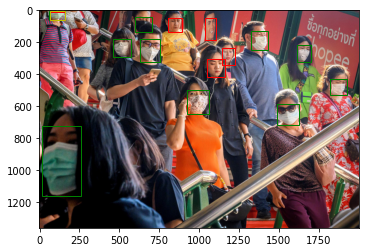

Real


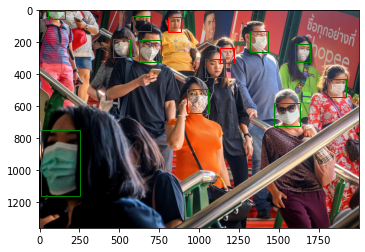

Prediccion


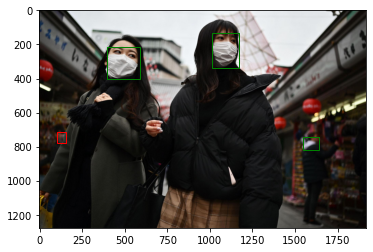

Real


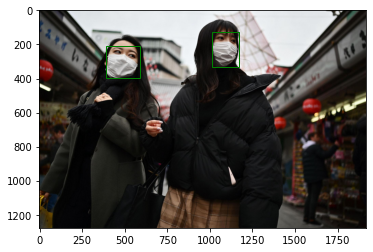

Prediccion


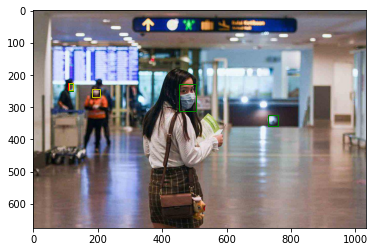

Real


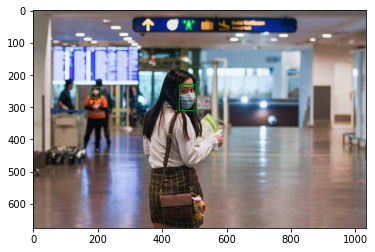

Prediccion


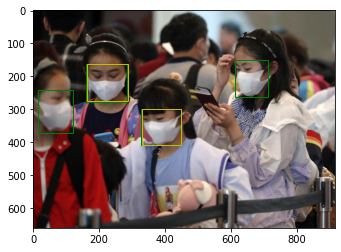

Real


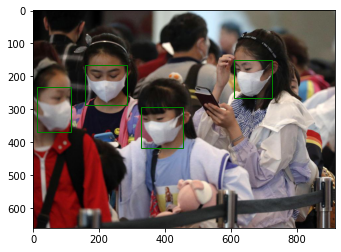

In [ ]:
for i in range(4):
  print('Prediccion')
  plot_image(imgs[i],preds[i])
  print('Real')
  plot_image(imgs[i],annotations[i])

In [ ]:
i = 0
for imgs, annotations in data_loader_train:
  i += 1
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  model.eval()
  preds = model(imgs)
  print('Prediccion')
  plot_image(imgs[i],preds[i])
  print('Real')
  plot_image(imgs[i],annotations[i])
  if i >10:
    break

# Save Model

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Diplomado Aplicaciones IA/Visión Computacional/model_zombie.pth')